## Crypto Prediction with LSTM: Ethereum (ETH)

- This notebook attempts to use TensorFlow Keras LSTM to predict movement in Crypto prices
- Data is pulled from the CoinApi, so it can be refreshed at any point and retrained
- The models use a 7 day lookback window to produce series data for training and testing
- 2 optimizations were used and an overall R2 score of .90 was attained

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tensorflow as tf
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import datetime as dt


from api_keys import coinapi_key

2023-10-23 14:55:32.670469: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Pull ETH data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_ETH_USD/history?period_id=1DAY&limit=20000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-10-23T00:00:00.0000000Z', 'time_period_end': '2023-10-24T00:00:00.0000000Z', 'time_open': '2023-10-23T00:00:52.0870000Z', 'time_close': '2023-10-23T18:55:34.3600000Z', 'price_open': 1664.1, 'price_high': 1706.2, 'price_low': 1658.6, 'price_close': 1699.5, 'volume_traded': 4428.00154225, 'trades_count': 5125}, {'time_period_start': '2023-10-22T00:00:00.0000000Z', 'time_period_end': '2023-10-23T00:00:00.0000000Z', 'time_open': '2023-10-22T00:00:06.9530000Z', 'time_close': '2023-10-22T23:59:37.9850000Z', 'price_open': 1629.8, 'price_high': 1668.5, 'price_low': 1623, 'price_close': 1664.1, 'volume_traded': 1654.78573908, 'trades_count': 3834}, {'time_period_start': '2023-10-21T00:00:00.0000000Z', 'time_period_end': '2023-10-22T00:00:00.0000000Z', 'time_open': '2023-10-21T00:00:04.2620000Z', 'time_close': '2023-10-21T23:59:53.6660000Z', 'price_open': 1605, 'price_high': 1642.5, 'price_low': 1593.2, 'price_close': 1629.7, 'volume_traded': 2200.02199899, 'trades_c

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-10-23T00:00:00.0000000Z,2023-10-24T00:00:00.0000000Z,2023-10-23T00:00:52.0870000Z,2023-10-23T18:55:34.3600000Z,1664.1,1706.2,1658.6,1699.5,4428.001542,5125
1,2023-10-22T00:00:00.0000000Z,2023-10-23T00:00:00.0000000Z,2023-10-22T00:00:06.9530000Z,2023-10-22T23:59:37.9850000Z,1629.8,1668.5,1623.0,1664.1,1654.785739,3834
2,2023-10-21T00:00:00.0000000Z,2023-10-22T00:00:00.0000000Z,2023-10-21T00:00:04.2620000Z,2023-10-21T23:59:53.6660000Z,1605.0,1642.5,1593.2,1629.7,2200.021999,4006
3,2023-10-20T00:00:00.0000000Z,2023-10-21T00:00:00.0000000Z,2023-10-20T00:00:45.0870000Z,2023-10-20T23:58:00.7190000Z,1567.6,1631.2,1562.2,1604.9,4502.714157,5956
4,2023-10-19T00:00:00.0000000Z,2023-10-20T00:00:00.0000000Z,2023-10-19T00:00:23.6270000Z,2023-10-19T23:59:39.3040000Z,1563.2,1575.1,1542.1,1567.7,1831.849108,4746


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data.head()

,Close
Date,
2017-08-20,298.40
2017-08-21,319.31
2017-08-22,312.22
2017-08-23,315.61
2017-08-24,323.84


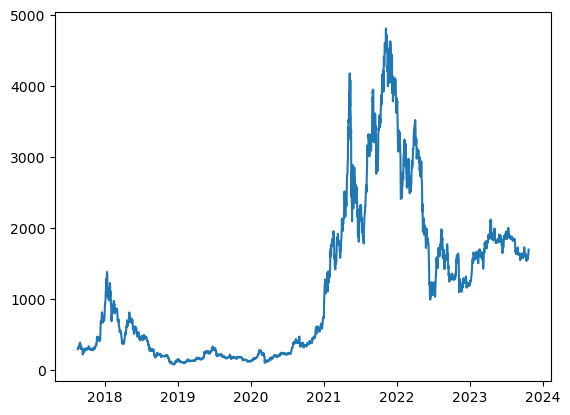

In [5]:
#plot historical eth price
plt.plot(data)

In [6]:
# Set parameters for model

lookback = 7

split_1 = .8
split_2 = .9

In [7]:
# build lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

shifted_df = prepare_dataframe_for_lstm(data, lookback)

# name date column from new index (since start date is absorbed into first x windows)
dates = shifted_df.index

#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

# scale to log
log_transformed_data = np.log(shifted_df_as_np)



# split y from features series
X1 = log_transformed_data[:, 1:]
y1 = log_transformed_data[:, 0]

#flip order of windows (needs to start with most recent)

X1 = dc(np.flip(X1, axis=1))
X1


X1.shape, y1.shape, dates.shape


((2239, 7), (2239,), (2239,))

In [42]:
#Calculate split points based on previously defined variables
train_split = int(len(X1) * split_1)
test_split = int(len(X1) * split_2)

#Define spilt points for train/val/test
dates_train1, X_train1, y_train1 = dates[:train_split],X1[:train_split], y1[:train_split]
dates_val1, X_val1, y_val1 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test1, X_test1, y_test1 = dates[test_split:], X1[test_split:], y1[test_split:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1119, 7), (1119,), (873, 7), (873,), (247, 7), (247,))

In [57]:
#Build, compile, fit LSTM model

model = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300)

Epoch 1/300
35/35 [==============================] - 19s 120ms/step - loss: 17.6453 - mean_absolute_error: 3.8299 - val_loss: 2.5158 - val_mean_absolute_error: 1.4680
Epoch 2/300
35/35 [==============================] - 1s 27ms/step - loss: 0.6533 - mean_absolute_error: 0.6560 - val_loss: 2.8636 - val_mean_absolute_error: 1.5770
Epoch 3/300
35/35 [==============================] - 1s 25ms/step - loss: 0.3122 - mean_absolute_error: 0.4577 - val_loss: 3.3587 - val_mean_absolute_error: 1.7307
Epoch 4/300
35/35 [==============================] - 1s 29ms/step - loss: 0.2794 - mean_absolute_error: 0.4284 - val_loss: 3.3809 - val_mean_absolute_error: 1.7430
Epoch 5/300
35/35 [==============================] - 1s 26ms/step - loss: 0.2511 - mean_absolute_error: 0.4038 - val_loss: 2.8853 - val_mean_absolute_error: 1.6042
Epoch 6/300
35/35 [==============================] - 1s 24ms/step - loss: 0.2094 - mean_absolute_error: 0.3709 - val_loss: 2.4249 - val_mean_absolute_error: 1.4714
Epoch 7/300
3

Epoch 51/300
35/35 [==============================] - 1s 18ms/step - loss: 0.0051 - mean_absolute_error: 0.0530 - val_loss: 0.0711 - val_mean_absolute_error: 0.2126
Epoch 52/300
35/35 [==============================] - 1s 19ms/step - loss: 0.0054 - mean_absolute_error: 0.0555 - val_loss: 0.0610 - val_mean_absolute_error: 0.1920
Epoch 53/300
35/35 [==============================] - 1s 16ms/step - loss: 0.0044 - mean_absolute_error: 0.0476 - val_loss: 0.0791 - val_mean_absolute_error: 0.2315
Epoch 54/300
35/35 [==============================] - 1s 18ms/step - loss: 0.0056 - mean_absolute_error: 0.0567 - val_loss: 0.0819 - val_mean_absolute_error: 0.2344
Epoch 55/300
35/35 [==============================] - 1s 18ms/step - loss: 0.0043 - mean_absolute_error: 0.0460 - val_loss: 0.0703 - val_mean_absolute_error: 0.2119
Epoch 56/300
35/35 [==============================] - 1s 17ms/step - loss: 0.0048 - mean_absolute_error: 0.0511 - val_loss: 0.0627 - val_mean_absolute_error: 0.1968
Epoch 57/3

Epoch 101/300
35/35 [==============================] - 1s 21ms/step - loss: 0.0045 - mean_absolute_error: 0.0509 - val_loss: 0.0389 - val_mean_absolute_error: 0.1541
Epoch 102/300
35/35 [==============================] - 1s 19ms/step - loss: 0.0036 - mean_absolute_error: 0.0419 - val_loss: 0.0400 - val_mean_absolute_error: 0.1568
Epoch 103/300
35/35 [==============================] - 1s 30ms/step - loss: 0.0042 - mean_absolute_error: 0.0474 - val_loss: 0.0510 - val_mean_absolute_error: 0.1855
Epoch 104/300
35/35 [==============================] - 1s 22ms/step - loss: 0.0055 - mean_absolute_error: 0.0568 - val_loss: 0.0381 - val_mean_absolute_error: 0.1530
Epoch 105/300
35/35 [==============================] - 1s 24ms/step - loss: 0.0046 - mean_absolute_error: 0.0503 - val_loss: 0.0481 - val_mean_absolute_error: 0.1776
Epoch 106/300
35/35 [==============================] - 1s 20ms/step - loss: 0.0040 - mean_absolute_error: 0.0454 - val_loss: 0.0529 - val_mean_absolute_error: 0.1904
Epoc

35/35 [==============================] - 0s 11ms/step - loss: 0.0038 - mean_absolute_error: 0.0447 - val_loss: 0.0353 - val_mean_absolute_error: 0.1532
Epoch 151/300
35/35 [==============================] - 0s 11ms/step - loss: 0.0033 - mean_absolute_error: 0.0401 - val_loss: 0.0370 - val_mean_absolute_error: 0.1598
Epoch 152/300
35/35 [==============================] - 0s 11ms/step - loss: 0.0038 - mean_absolute_error: 0.0450 - val_loss: 0.0332 - val_mean_absolute_error: 0.1482
Epoch 153/300
35/35 [==============================] - 0s 11ms/step - loss: 0.0040 - mean_absolute_error: 0.0461 - val_loss: 0.0214 - val_mean_absolute_error: 0.1136
Epoch 154/300
35/35 [==============================] - 0s 11ms/step - loss: 0.0041 - mean_absolute_error: 0.0478 - val_loss: 0.0320 - val_mean_absolute_error: 0.1440
Epoch 155/300
35/35 [==============================] - 0s 11ms/step - loss: 0.0049 - mean_absolute_error: 0.0549 - val_loss: 0.0373 - val_mean_absolute_error: 0.1580
Epoch 156/300
35/3

35/35 [==============================] - 0s 11ms/step - loss: 0.0048 - mean_absolute_error: 0.0531 - val_loss: 0.0217 - val_mean_absolute_error: 0.1177
Epoch 200/300
35/35 [==============================] - 0s 11ms/step - loss: 0.0036 - mean_absolute_error: 0.0434 - val_loss: 0.0280 - val_mean_absolute_error: 0.1392
Epoch 201/300
35/35 [==============================] - 0s 12ms/step - loss: 0.0033 - mean_absolute_error: 0.0400 - val_loss: 0.0272 - val_mean_absolute_error: 0.1393
Epoch 202/300
35/35 [==============================] - 0s 10ms/step - loss: 0.0041 - mean_absolute_error: 0.0463 - val_loss: 0.0257 - val_mean_absolute_error: 0.1323
Epoch 203/300
35/35 [==============================] - 0s 10ms/step - loss: 0.0032 - mean_absolute_error: 0.0391 - val_loss: 0.0244 - val_mean_absolute_error: 0.1303
Epoch 204/300
35/35 [==============================] - 0s 11ms/step - loss: 0.0039 - mean_absolute_error: 0.0467 - val_loss: 0.0223 - val_mean_absolute_error: 0.1214
Epoch 205/300
35/3

35/35 [==============================] - 1s 24ms/step - loss: 0.0036 - mean_absolute_error: 0.0429 - val_loss: 0.0118 - val_mean_absolute_error: 0.0845
Epoch 249/300
35/35 [==============================] - 1s 22ms/step - loss: 0.0034 - mean_absolute_error: 0.0401 - val_loss: 0.0155 - val_mean_absolute_error: 0.1029
Epoch 250/300
35/35 [==============================] - 1s 26ms/step - loss: 0.0033 - mean_absolute_error: 0.0404 - val_loss: 0.0121 - val_mean_absolute_error: 0.0860
Epoch 251/300
35/35 [==============================] - 1s 22ms/step - loss: 0.0033 - mean_absolute_error: 0.0409 - val_loss: 0.0319 - val_mean_absolute_error: 0.1578
Epoch 252/300
35/35 [==============================] - 1s 22ms/step - loss: 0.0033 - mean_absolute_error: 0.0404 - val_loss: 0.0165 - val_mean_absolute_error: 0.1032
Epoch 253/300
35/35 [==============================] - 1s 22ms/step - loss: 0.0035 - mean_absolute_error: 0.0418 - val_loss: 0.0085 - val_mean_absolute_error: 0.0715
Epoch 254/300
35/3

35/35 [==============================] - 0s 13ms/step - loss: 0.0039 - mean_absolute_error: 0.0457 - val_loss: 0.0232 - val_mean_absolute_error: 0.1308
Epoch 298/300
35/35 [==============================] - 0s 14ms/step - loss: 0.0038 - mean_absolute_error: 0.0452 - val_loss: 0.0103 - val_mean_absolute_error: 0.0794
Epoch 299/300
35/35 [==============================] - 0s 11ms/step - loss: 0.0051 - mean_absolute_error: 0.0553 - val_loss: 0.0083 - val_mean_absolute_error: 0.0706
Epoch 300/300
35/35 [==============================] - 0s 10ms/step - loss: 0.0054 - mean_absolute_error: 0.0560 - val_loss: 0.0075 - val_mean_absolute_error: 0.0670


35/35 [==============================] - 1s 3ms/step


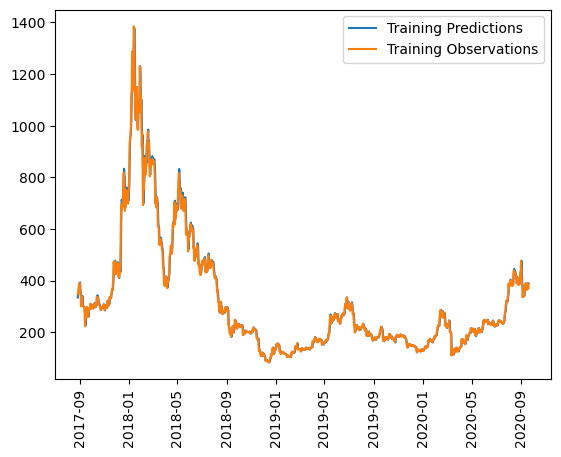

In [58]:
# Check training predictions (use np.exp to transform scaled data back to original scale)

train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [59]:
# Check scores for val period
score = model.evaluate(X_val1, y_val1, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.007526762783527374
Val MAE: 0.06704189628362656


28/28 [==============================] - 0s 3ms/step


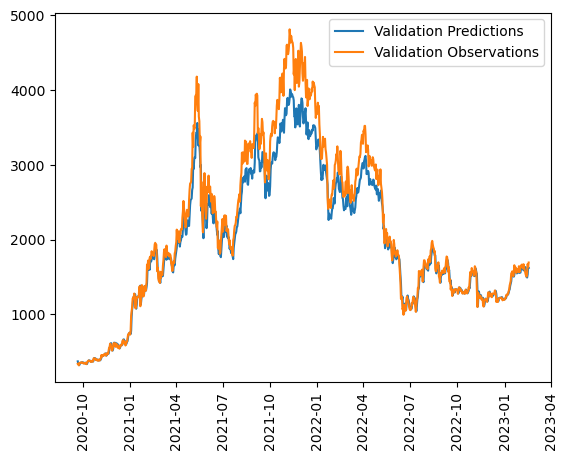

In [60]:
# graphed performance of val data in model
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, np.exp(val_predictions))
plt.plot(dates_val1, np.exp(y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [61]:
score = model.evaluate(X_test1, y_test1, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.001113728154450655
Test MAE: 0.02791959047317505


8/8 [==============================] - 0s 3ms/step


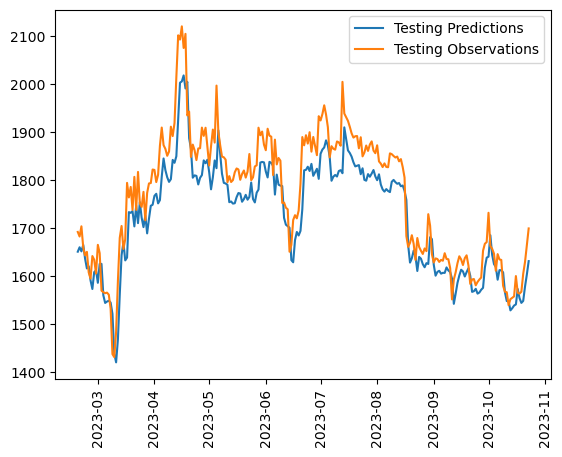

In [62]:
#check model against test data
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1, np.exp(test_predictions))
plt.plot(dates_test1, np.exp(y_test1))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [63]:
# Check r2 score
print('R2 Score: ', r2_score(y_test1, test_predictions))

R2 Score:  0.8044029746131115


## Optimization of the Model

- Adjust the initial data used, limited to the last 50% of the data
- Focus more on recent trends for learning
- Increase Epochs
- Slow learning rate

In [16]:
# Split is changed to begin at 50% of the dataset and continue to the end.
split_1 = .5
split_2 = .89
split_3 = .95


initial_split = int(len(X1) * split_1)
train_split = int(len(X1) * split_2)
test_split = int(len(X1) * split_3)

In [17]:
#change timeframe

dates_train2, X_train2, y_train2 = dates[initial_split:train_split],X1[initial_split:train_split], y1[initial_split:train_split]
dates_val2, X_val2, y_val2 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test2, X_test2, y_test2 = dates[test_split:], X1[test_split:], y1[test_split:]
dates_train2.shape, X_train2.shape, y_train2.shape, \
dates_val2.shape, X_val2.shape, y_val2.shape, \
dates_test2.shape, X_test2.shape, y_test2.shape

((873,), (873, 7), (873,), (135,), (135, 7), (135,), (112,), (112, 7), (112,))

In [18]:
# Build, compile and fit the new model- increased epochs, smaller learning rate
model2 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=200)

Epoch 1/200
28/28 [==============================] - 10s 75ms/step - loss: 49.7636 - mean_absolute_error: 7.0262 - val_loss: 46.9791 - val_mean_absolute_error: 6.8538
Epoch 2/200
28/28 [==============================] - 0s 14ms/step - loss: 44.7648 - mean_absolute_error: 6.6606 - val_loss: 41.1627 - val_mean_absolute_error: 6.4154
Epoch 3/200
28/28 [==============================] - 0s 11ms/step - loss: 38.4866 - mean_absolute_error: 6.1714 - val_loss: 34.5918 - val_mean_absolute_error: 5.8811
Epoch 4/200
28/28 [==============================] - 0s 14ms/step - loss: 31.6040 - mean_absolute_error: 5.5858 - val_loss: 27.1798 - val_mean_absolute_error: 5.2130
Epoch 5/200
28/28 [==============================] - 0s 16ms/step - loss: 23.5073 - mean_absolute_error: 4.8051 - val_loss: 18.4585 - val_mean_absolute_error: 4.2957
Epoch 6/200
28/28 [==============================] - 0s 14ms/step - loss: 14.5049 - mean_absolute_error: 3.7406 - val_loss: 9.4304 - val_mean_absolute_error: 3.0700
Epoc

28/28 [==============================] - 0s 11ms/step - loss: 0.0136 - mean_absolute_error: 0.0931 - val_loss: 0.0014 - val_mean_absolute_error: 0.0294
Epoch 51/200
28/28 [==============================] - 0s 15ms/step - loss: 0.0103 - mean_absolute_error: 0.0811 - val_loss: 0.0020 - val_mean_absolute_error: 0.0364
Epoch 52/200
28/28 [==============================] - 0s 14ms/step - loss: 0.0087 - mean_absolute_error: 0.0736 - val_loss: 0.0014 - val_mean_absolute_error: 0.0281
Epoch 53/200
28/28 [==============================] - 0s 14ms/step - loss: 0.0077 - mean_absolute_error: 0.0684 - val_loss: 0.0015 - val_mean_absolute_error: 0.0303
Epoch 54/200
28/28 [==============================] - 0s 13ms/step - loss: 0.0072 - mean_absolute_error: 0.0658 - val_loss: 0.0021 - val_mean_absolute_error: 0.0371
Epoch 55/200
28/28 [==============================] - 0s 13ms/step - loss: 0.0067 - mean_absolute_error: 0.0627 - val_loss: 0.0014 - val_mean_absolute_error: 0.0278
Epoch 56/200
28/28 [===

Epoch 100/200
28/28 [==============================] - 0s 14ms/step - loss: 0.0058 - mean_absolute_error: 0.0574 - val_loss: 0.0020 - val_mean_absolute_error: 0.0358
Epoch 101/200
28/28 [==============================] - 0s 12ms/step - loss: 0.0059 - mean_absolute_error: 0.0571 - val_loss: 0.0021 - val_mean_absolute_error: 0.0377
Epoch 102/200
28/28 [==============================] - 0s 14ms/step - loss: 0.0057 - mean_absolute_error: 0.0566 - val_loss: 0.0014 - val_mean_absolute_error: 0.0276
Epoch 103/200
28/28 [==============================] - 0s 13ms/step - loss: 0.0057 - mean_absolute_error: 0.0565 - val_loss: 0.0016 - val_mean_absolute_error: 0.0316
Epoch 104/200
28/28 [==============================] - 0s 12ms/step - loss: 0.0058 - mean_absolute_error: 0.0571 - val_loss: 0.0025 - val_mean_absolute_error: 0.0420
Epoch 105/200
28/28 [==============================] - 0s 13ms/step - loss: 0.0061 - mean_absolute_error: 0.0586 - val_loss: 0.0017 - val_mean_absolute_error: 0.0330
Epoc

28/28 [==============================] - 0s 12ms/step - loss: 0.0054 - mean_absolute_error: 0.0550 - val_loss: 0.0015 - val_mean_absolute_error: 0.0296
Epoch 150/200
28/28 [==============================] - 0s 13ms/step - loss: 0.0055 - mean_absolute_error: 0.0555 - val_loss: 0.0020 - val_mean_absolute_error: 0.0365
Epoch 151/200
28/28 [==============================] - 0s 13ms/step - loss: 0.0056 - mean_absolute_error: 0.0560 - val_loss: 0.0018 - val_mean_absolute_error: 0.0334
Epoch 152/200
28/28 [==============================] - 0s 12ms/step - loss: 0.0055 - mean_absolute_error: 0.0554 - val_loss: 0.0015 - val_mean_absolute_error: 0.0303
Epoch 153/200
28/28 [==============================] - 0s 14ms/step - loss: 0.0054 - mean_absolute_error: 0.0549 - val_loss: 0.0013 - val_mean_absolute_error: 0.0269
Epoch 154/200
28/28 [==============================] - 0s 13ms/step - loss: 0.0056 - mean_absolute_error: 0.0569 - val_loss: 0.0016 - val_mean_absolute_error: 0.0303
Epoch 155/200
28/2

28/28 [==============================] - 0s 17ms/step - loss: 0.0054 - mean_absolute_error: 0.0559 - val_loss: 0.0015 - val_mean_absolute_error: 0.0303
Epoch 199/200
28/28 [==============================] - 0s 14ms/step - loss: 0.0053 - mean_absolute_error: 0.0545 - val_loss: 0.0013 - val_mean_absolute_error: 0.0279
Epoch 200/200
28/28 [==============================] - 1s 29ms/step - loss: 0.0053 - mean_absolute_error: 0.0546 - val_loss: 0.0012 - val_mean_absolute_error: 0.0260


28/28 [==============================] - 3s 9ms/step


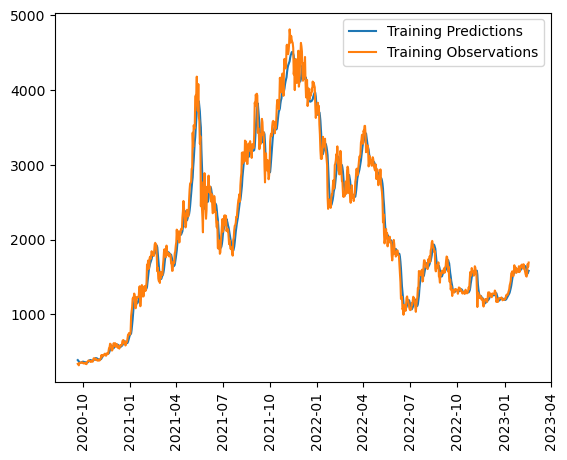

In [19]:
#Second model observations
train_predictions2 = model2.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions2))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [20]:
score = model2.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.001215146156027913
Val MAE: 0.026028428226709366


5/5 [==============================] - 0s 7ms/step


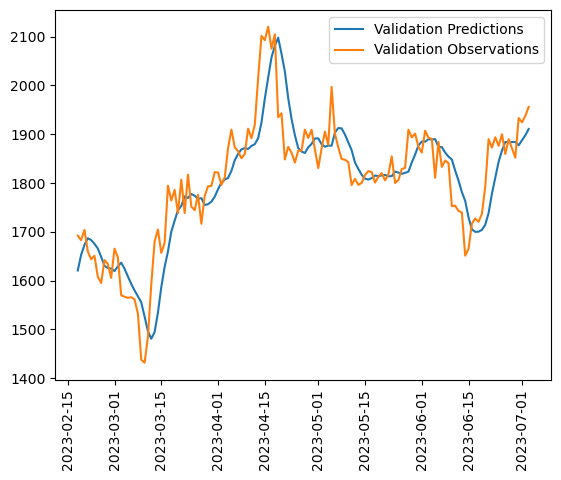

In [21]:
#Second model observations
val_predictions2 = model2.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions2))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [22]:
#MSAE Score for second model
score = model2.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0005436048959381878
Test MAE: 0.016224751248955727


In [23]:
# R2 score for second model
y_pred = model2.predict(X_test2)
print('R2 Score: ', r2_score(y_test2, y_pred))

4/4 [==============================] - 0s 8ms/step
R2 Score:  0.8950311720498041


4/4 [==============================] - 0s 7ms/step


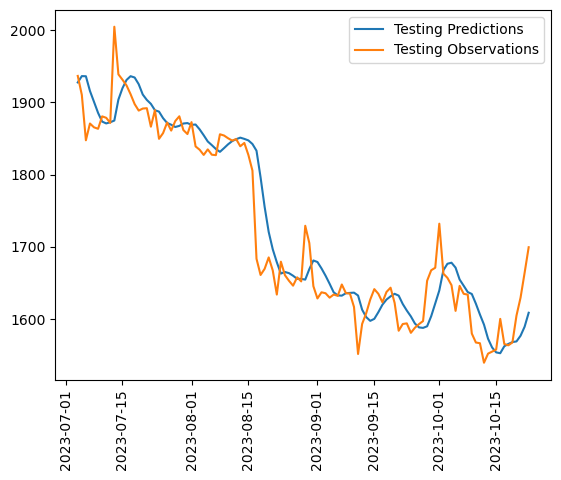

In [24]:
#Second model observations
test_predictions2 = model2.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions2))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [25]:
# Second optimization. Increased neural density, epochs
model3 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

model3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=300)

Epoch 1/300
28/28 [==============================] - 11s 111ms/step - loss: 27.0862 - mean_absolute_error: 4.6081 - val_loss: 4.2396 - val_mean_absolute_error: 2.0579
Epoch 2/300
28/28 [==============================] - 0s 12ms/step - loss: 1.2454 - mean_absolute_error: 0.9006 - val_loss: 0.2151 - val_mean_absolute_error: 0.4588
Epoch 3/300
28/28 [==============================] - 0s 14ms/step - loss: 0.3842 - mean_absolute_error: 0.4880 - val_loss: 0.0250 - val_mean_absolute_error: 0.1437
Epoch 4/300
28/28 [==============================] - 0s 14ms/step - loss: 0.3203 - mean_absolute_error: 0.4452 - val_loss: 0.0151 - val_mean_absolute_error: 0.1070
Epoch 5/300
28/28 [==============================] - 0s 13ms/step - loss: 0.2954 - mean_absolute_error: 0.4271 - val_loss: 0.0123 - val_mean_absolute_error: 0.0955
Epoch 6/300
28/28 [==============================] - 0s 13ms/step - loss: 0.2538 - mean_absolute_error: 0.3990 - val_loss: 0.0044 - val_mean_absolute_error: 0.0551
Epoch 7/300
2

28/28 [==============================] - 0s 12ms/step - loss: 0.0051 - mean_absolute_error: 0.0543 - val_loss: 8.9114e-04 - val_mean_absolute_error: 0.0221
Epoch 51/300
28/28 [==============================] - 0s 14ms/step - loss: 0.0044 - mean_absolute_error: 0.0496 - val_loss: 0.0051 - val_mean_absolute_error: 0.0663
Epoch 52/300
28/28 [==============================] - 0s 13ms/step - loss: 0.0048 - mean_absolute_error: 0.0526 - val_loss: 0.0013 - val_mean_absolute_error: 0.0280
Epoch 53/300
28/28 [==============================] - 0s 14ms/step - loss: 0.0043 - mean_absolute_error: 0.0506 - val_loss: 0.0024 - val_mean_absolute_error: 0.0425
Epoch 54/300
28/28 [==============================] - 0s 12ms/step - loss: 0.0046 - mean_absolute_error: 0.0511 - val_loss: 0.0039 - val_mean_absolute_error: 0.0567
Epoch 55/300
28/28 [==============================] - 0s 13ms/step - loss: 0.0047 - mean_absolute_error: 0.0520 - val_loss: 8.8727e-04 - val_mean_absolute_error: 0.0222
Epoch 56/300
28

28/28 [==============================] - 0s 16ms/step - loss: 0.0033 - mean_absolute_error: 0.0419 - val_loss: 0.0025 - val_mean_absolute_error: 0.0444
Epoch 100/300
28/28 [==============================] - 0s 17ms/step - loss: 0.0035 - mean_absolute_error: 0.0442 - val_loss: 9.4265e-04 - val_mean_absolute_error: 0.0238
Epoch 101/300
28/28 [==============================] - 0s 14ms/step - loss: 0.0039 - mean_absolute_error: 0.0477 - val_loss: 9.3242e-04 - val_mean_absolute_error: 0.0229
Epoch 102/300
28/28 [==============================] - 1s 18ms/step - loss: 0.0035 - mean_absolute_error: 0.0444 - val_loss: 0.0066 - val_mean_absolute_error: 0.0764
Epoch 103/300
28/28 [==============================] - 0s 16ms/step - loss: 0.0042 - mean_absolute_error: 0.0500 - val_loss: 8.6942e-04 - val_mean_absolute_error: 0.0225
Epoch 104/300
28/28 [==============================] - 0s 14ms/step - loss: 0.0046 - mean_absolute_error: 0.0525 - val_loss: 0.0064 - val_mean_absolute_error: 0.0754
Epoch 

28/28 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_absolute_error: 0.0442 - val_loss: 6.7951e-04 - val_mean_absolute_error: 0.0189
Epoch 149/300
28/28 [==============================] - 0s 13ms/step - loss: 0.0038 - mean_absolute_error: 0.0462 - val_loss: 6.8726e-04 - val_mean_absolute_error: 0.0191
Epoch 150/300
28/28 [==============================] - 0s 12ms/step - loss: 0.0046 - mean_absolute_error: 0.0532 - val_loss: 0.0050 - val_mean_absolute_error: 0.0665
Epoch 151/300
28/28 [==============================] - 0s 16ms/step - loss: 0.0051 - mean_absolute_error: 0.0563 - val_loss: 0.0095 - val_mean_absolute_error: 0.0939
Epoch 152/300
28/28 [==============================] - 0s 15ms/step - loss: 0.0047 - mean_absolute_error: 0.0542 - val_loss: 0.0013 - val_mean_absolute_error: 0.0297
Epoch 153/300
28/28 [==============================] - 0s 11ms/step - loss: 0.0034 - mean_absolute_error: 0.0445 - val_loss: 8.0665e-04 - val_mean_absolute_error: 0.0213
Epoch 

28/28 [==============================] - 0s 17ms/step - loss: 0.0034 - mean_absolute_error: 0.0437 - val_loss: 8.0573e-04 - val_mean_absolute_error: 0.0216
Epoch 198/300
28/28 [==============================] - 0s 11ms/step - loss: 0.0041 - mean_absolute_error: 0.0503 - val_loss: 6.3997e-04 - val_mean_absolute_error: 0.0183
Epoch 199/300
28/28 [==============================] - 0s 12ms/step - loss: 0.0030 - mean_absolute_error: 0.0412 - val_loss: 0.0069 - val_mean_absolute_error: 0.0790
Epoch 200/300
28/28 [==============================] - 0s 11ms/step - loss: 0.0035 - mean_absolute_error: 0.0444 - val_loss: 0.0014 - val_mean_absolute_error: 0.0326
Epoch 201/300
28/28 [==============================] - 0s 11ms/step - loss: 0.0045 - mean_absolute_error: 0.0525 - val_loss: 0.0081 - val_mean_absolute_error: 0.0862
Epoch 202/300
28/28 [==============================] - 0s 13ms/step - loss: 0.0051 - mean_absolute_error: 0.0580 - val_loss: 0.0034 - val_mean_absolute_error: 0.0532
Epoch 203/

28/28 [==============================] - 0s 11ms/step - loss: 0.0035 - mean_absolute_error: 0.0451 - val_loss: 0.0010 - val_mean_absolute_error: 0.0253
Epoch 247/300
28/28 [==============================] - 1s 18ms/step - loss: 0.0033 - mean_absolute_error: 0.0439 - val_loss: 0.0014 - val_mean_absolute_error: 0.0311
Epoch 248/300
28/28 [==============================] - 1s 25ms/step - loss: 0.0043 - mean_absolute_error: 0.0512 - val_loss: 0.0032 - val_mean_absolute_error: 0.0519
Epoch 249/300
28/28 [==============================] - 0s 13ms/step - loss: 0.0034 - mean_absolute_error: 0.0447 - val_loss: 0.0010 - val_mean_absolute_error: 0.0259
Epoch 250/300
28/28 [==============================] - 1s 20ms/step - loss: 0.0030 - mean_absolute_error: 0.0407 - val_loss: 8.9192e-04 - val_mean_absolute_error: 0.0233
Epoch 251/300
28/28 [==============================] - 0s 15ms/step - loss: 0.0036 - mean_absolute_error: 0.0466 - val_loss: 0.0029 - val_mean_absolute_error: 0.0486
Epoch 252/300


28/28 [==============================] - 0s 11ms/step - loss: 0.0037 - mean_absolute_error: 0.0472 - val_loss: 8.3611e-04 - val_mean_absolute_error: 0.0232
Epoch 296/300
28/28 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_absolute_error: 0.0466 - val_loss: 7.8492e-04 - val_mean_absolute_error: 0.0221
Epoch 297/300
28/28 [==============================] - 0s 11ms/step - loss: 0.0034 - mean_absolute_error: 0.0447 - val_loss: 0.0023 - val_mean_absolute_error: 0.0422
Epoch 298/300
28/28 [==============================] - 0s 11ms/step - loss: 0.0034 - mean_absolute_error: 0.0450 - val_loss: 0.0097 - val_mean_absolute_error: 0.0954
Epoch 299/300
28/28 [==============================] - 0s 11ms/step - loss: 0.0048 - mean_absolute_error: 0.0538 - val_loss: 0.0038 - val_mean_absolute_error: 0.0566
Epoch 300/300
28/28 [==============================] - 0s 13ms/step - loss: 0.0032 - mean_absolute_error: 0.0428 - val_loss: 0.0013 - val_mean_absolute_error: 0.0302


28/28 [==============================] - 1s 4ms/step


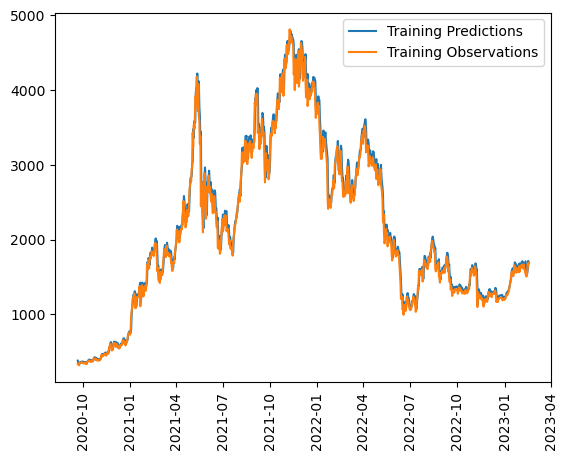

In [26]:
#Third model observations
train_predictions3 = model3.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions3))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [27]:
score = model3.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0012640290660783648
Val MAE: 0.030164213851094246


5/5 [==============================] - 0s 4ms/step


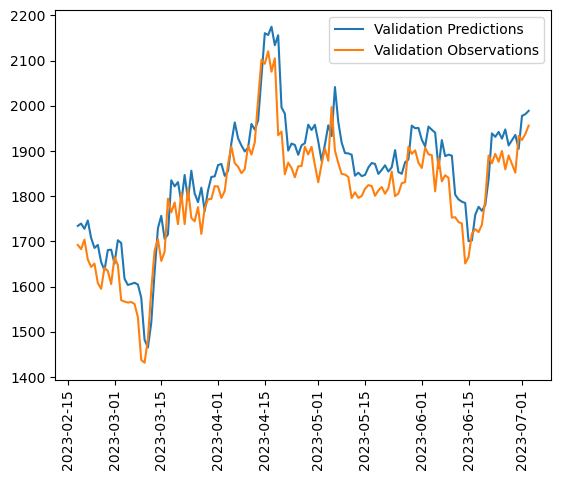

In [28]:
#Second model observations 
val_predictions3 = model3.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions3))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [29]:
# Third Model MAE score
score = model3.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0010502125369384885
Test MAE: 0.0288167092949152


4/4 [==============================] - 0s 5ms/step


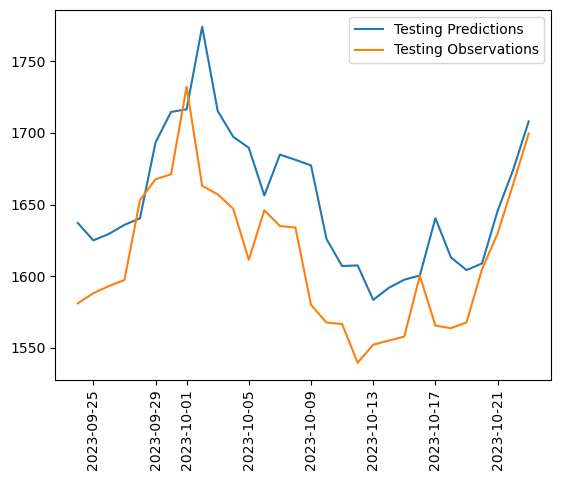

In [30]:
test_predictions3 = model3.predict(X_test2).flatten()

plt.plot(dates_test2[-30:], np.exp(test_predictions3[-30:]))
plt.plot(dates_test2[-30:],np.exp(y_test2[-30:]))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [31]:
# R2 score for second model

print('R2 Score: ', r2_score(y_test2, test_predictions3))

R2 Score:  0.797207086408126


## Future Prediction
- Attempting to look ahead x days in an attempt to predict upcoming trends
- We are using the best scoring model for testing predictions

In [32]:
# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 7
#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = X_test2[-1]
current_reshape = current_batch.reshape((1, lookback, 1))
initial_date = dates_test2[-1]

# Generate predictions for 7 days
for i in range(prediction_range): # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model3.predict(current_reshape)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        

    # Update initial input for the next step
    updated_batch = np.insert(current_batch, -1, current_pred)
    
    #resize batch 
    current_batch = updated_batch[1:]
    
    #reshape batch
    current_reshape = current_batch.reshape((1, lookback, 1))

#Adding future dates at the end of the dateset   
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
# 'predictions' contains 7-day forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 113ms/step
[7.4430656, 7.447928, 7.445768, 7.4444637, 7.4445186, 7.4448357, 7.4449067]
2023-10-24
2023-10-25
2023-10-26
2023-10-27
2023-10-28
2023-10-29
2023-10-30


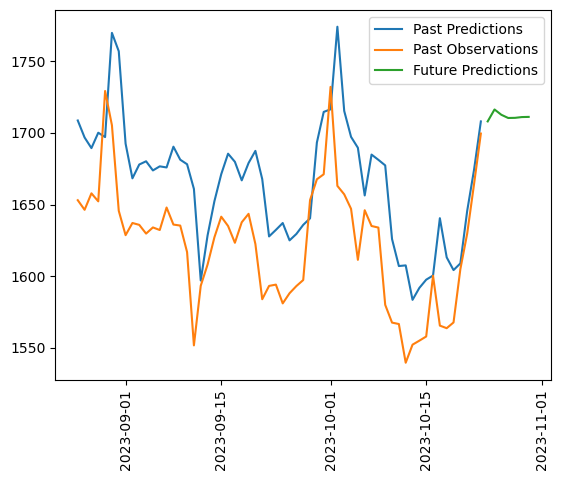

In [33]:
#Plot last 60 days of testing plus future prediction
plt.plot(dates_test2[-60:], np.exp(test_predictions3[-60:]))
plt.plot(dates_test2[-60:],np.exp(y_test2[-60:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

In [64]:
# Export model to HDF5 file
model.save("H5_Files/eth_7_day_1.h5")

In [65]:
# Export model to HDF5 file
model2.save("H5_Files/eth_7_day_2.h5")

In [66]:
# Export model to HDF5 file
model3.save("H5_Files/eth_7_day_3.h5")

In [67]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates_test2[-90:], "observed":np.exp(y_test2[-90:]),\
                "model_1_predicted":np.exp(test_predictions[-90:]),\
                "model_2_predicted":np.exp(test_predictions2[-90:]),\
                "model_3_predicted":np.exp(test_predictions3[-90:])})
df.set_index('Date', inplace=True)


df

,observed,model_1_predicted,model_2_predicted,model_3_predicted
Date,,,,
2023-07-26,1872.2,1798.924194,1871.560181,1903.564087
2023-07-27,1861.0,1812.668579,1869.122192,1920.823364
2023-07-28,1874.2,1807.167480,1865.988281,1912.103638
2023-07-29,1880.8,1813.747559,1867.522827,1922.403076
2023-07-30,1861.7,1821.183228,1870.814331,1930.821899
...,...,...,...,...
2023-10-19,1567.7,1544.412842,1568.153442,1604.231567
2023-10-20,1604.9,1548.505615,1569.119873,1608.902954
2023-10-21,1629.7,1578.497437,1576.943848,1645.549927


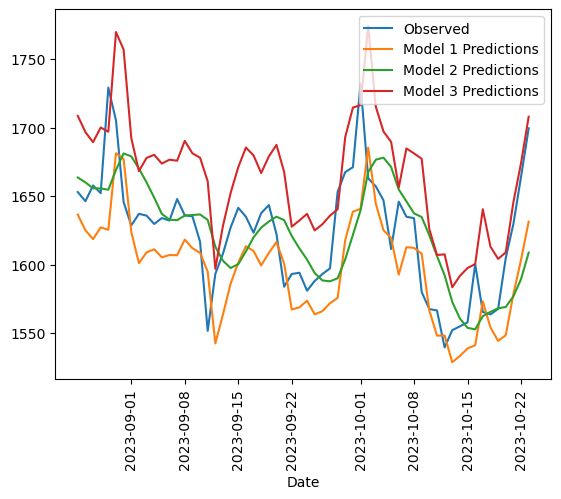

In [68]:
#Measuring each model's predictions against the test data
df[-60:].plot(use_index=True)
plt.xticks(rotation=90)

plt.legend(['Observed', 'Model 1 Predictions', 'Model 2 Predictions', \
            'Model 3 Predictions'])
plt.show()

In [69]:
#output prediction data to csv
df.to_csv('output/eth_predict.csv') 

In [70]:
#output original historical data to csv
data.to_csv('output/eth_lifetime.csv')

In [71]:
#Scores for each model

print('Model 1 R2 Score: ', r2_score(y_test1, test_predictions))
print('Model 2 R2 Score: ', r2_score(y_test2, test_predictions2))
print('Model 3 R2 Score: ', r2_score(y_test2, test_predictions3))

Model 1 R2 Score:  0.8044029746131115
Model 2 R2 Score:  0.8950311720498041
Model 3 R2 Score:  0.797207086408126
